In [1]:
!pip install tensorflow==2.13.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 80.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 90.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 26.0 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.9.0
    Uninstalling typing_extensions-4.9.0:
      Successfully uninstalled typing_extensions-4.9.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninsta

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import layers,losses,optimizers
from keras.applications import ResNet50V2
from keras.preprocessing.image import ImageDataGenerator
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [16]:
print(tf.__version__)

2.13.0


In [17]:
for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu,True)

In [18]:
train_dir = '/kaggle/input/cat-and-dog/training_set/training_set'
validation_dir = '/kaggle/input/cat-and-dog/training_set/training_set'


TRAIN_BATCH_SIZE = 24
VALIDATION_BATCH_SIZE = 64
IMAGE_SIZE = (244,244)
CLASS_MODE = 'categorical'

In [19]:
train_data = ImageDataGenerator(
    rescale = 1. /255,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    fill_mode = 'nearest',
    horizontal_flip = True,
    vertical_flip=True
)

train_generator = train_data.flow_from_directory(
    directory = train_dir,
    target_size = IMAGE_SIZE,
    class_mode = CLASS_MODE,
    batch_size = TRAIN_BATCH_SIZE,
    shuffle=True
)

validation_data = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)

validation_generator = validation_data.flow_from_directory(
    directory = validation_dir,
    target_size = IMAGE_SIZE,
    class_mode = CLASS_MODE,
    batch_size = VALIDATION_BATCH_SIZE
)

test_generator = validation_data.flow_from_directory(
    directory = validation_dir,
    target_size = IMAGE_SIZE,
    class_mode = CLASS_MODE,
    batch_size = VALIDATION_BATCH_SIZE,
    subset = 'validation'
)

print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

Found 8005 images belonging to 2 classes.
Found 8005 images belonging to 2 classes.
Found 1601 images belonging to 2 classes.
{'cats': 0, 'dogs': 1}
{'cats': 0, 'dogs': 1}
{'cats': 0, 'dogs': 1}


In [20]:
conv_base = ResNet50V2(
    weights = 'imagenet',
    include_top = False,
    input_shape = (244,244,3)
)

94668760/94668760 [==============================] - 8s 0us/step


In [21]:
conv_base.trainable = False

In [30]:
model = keras.models.Sequential([
    conv_base,
    layers.Flatten(),
    layers.Dense(2048,use_bias = False),
    layers.BatchNormalization(),
    layers.ReLU(),
    
    layers.Dense(4048),
    layers.Dropout(0.3),
    layers.ReLU(),
    
    layers.Dense(2,activation = 'softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 flatten_2 (Flatten)         (None, 131072)            0         
                                                                 
 dense_6 (Dense)             (None, 2048)              268435456 
                                                                 
 batch_normalization_2 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 re_lu_4 (ReLU)              (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 4048)              8294352   
                                                      

In [28]:
from keras.callbacks import ModelCheckpoint


checkpoint = ModelCheckpoint(filepath='cats_vs_dogs_epoch_val.h5',
                             monitor = 'val_acc',save_best_only = True,
                             mode = 'max',verbose = 1
                            )

model.compile(
    loss = losses.CategoricalCrossentropy(from_logits=False),
    optimizer = optimizers.Adam(1e-5),
    metrics = ['accuracy']
)

In [ ]:
epochs = 10

history = model.fit(
    train_generator,
    validation_data = test_generator,
    epochs = epochs,
    callbacks = [checkpoint]
)

In [23]:
model.evaluate(validation_generator)

126/126 ━━━━━━━━━━━━━━━━━━━━ 32s 256ms/step - accuracy: 0.9991 - loss: 0.0043


W0000 00:00:1713197028.948871     146 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[0.004190417006611824, 0.9991255402565002]

In [28]:
test_image_dir = '/kaggle/input/cats-and-dogs-image-classification/train'

valida = ImageDataGenerator(rescale = 1./255)

test_image_generator = valida.flow_from_directory(
    directory = test_image_dir,
    target_size = IMAGE_SIZE,
    class_mode = CLASS_MODE,
    batch_size = VALIDATION_BATCH_SIZE
)


print(test_image_generator.class_indices)

Found 557 images belonging to 2 classes.
{'cats': 0, 'dogs': 1}


In [59]:
model.evaluate(test_image_generator)

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 514ms/step - accuracy: 0.9598 - loss: 0.1217


[0.09785892814397812, 0.9605026841163635]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[0.9809756 0.0190244]]
Cat


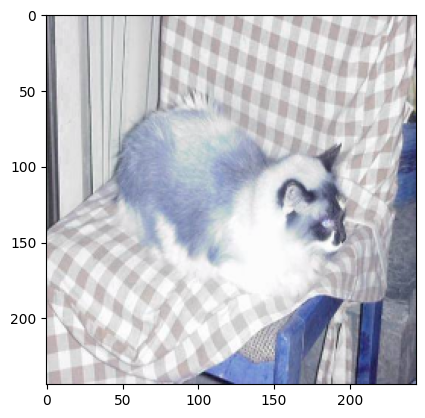

In [70]:
cate = ["Cat","Dog"]
# Load test image
test_img = cv2.imread('/kaggle/input/cat-and-dog/test_set/test_set/cats/cat.4011.jpg')
# Resize test image to match model input size (244x244)
test_img_resized = cv2.resize(test_img, (244, 244))
# Convert test image to numpy array
test_input = np.array(test_img_resized)
# Expand dimensions to match model input shape (add batch dimension)
test_input = np.expand_dims(test_input, axis=0)
# Normalize pixel values to range [0, 1]
test_input = test_input / 255.0
# Predict
y_pre = model.predict(test_input)
# Get predicted class
y_classes = [np.argmax(y_pre)][0]
print(y_pre)
# Print predicted class
print(cate[y_classes])
# Display the test image
plt.imshow(test_img_resized)
plt.show()

In [ ]:
model.save('/kaggle/working/cats_vs_dogs_ResNet50_new.h5')